In [1]:
import sys
sys.path.append("/lustre/storeB/users/arefk/MScThesis_AreKvanum2022_SeaIceML/SimpleUNET")
sys.path.append("/lustre/storeB/users/arefk/MScThesis_AreKvanum2022_SeaIceML/SimpleUNET/RunModel")

In [99]:
import glob

import tensorflow as tf
import numpy as np

from unet import create_MultiOutputUNET
from helper_functions import read_config_from_csv
from dataset import MultiOutputHDF5Generator
from predict_validation import numpy_where_wrapper

from matplotlib import pyplot as plt

In [3]:
path_model = "Data/models/"

config = read_config_from_csv(f"Data/models/weights_21021550.csv")

In [10]:
model = create_MultiOutputUNET(
        input_shape = (config['height'], config['width'], len(config['fields'])), 
        channels = config['channels'],
        pooling_factor = config['pooling_factor'],
        num_outputs = config['num_outputs'],
        # num_outputs = 1,
        average_pool = config['AveragePool'],
        leaky_relu = config['LeakyReLU']
    )

In [12]:
model_singleoutput = create_MultiOutputUNET(
        input_shape = (config['height'], config['width'], len(config['fields'])), 
        channels = config['channels'],
        pooling_factor = config['pooling_factor'],
        num_outputs = 1,
        average_pool = config['AveragePool'],
        leaky_relu = config['LeakyReLU']
    )

In [27]:
load_status = model.load_weights(f"Data/models/weights_21021550").expect_partial()

In [51]:
model_singleoutput.layers[0].set_weights(model.layers[0].get_weights())
model_singleoutput.layers[1].layers[0].set_weights(model.layers[1].layers[0].get_weights())
model_singleoutput.layers[1].layers[1].set_weights(model.layers[1].layers[1].get_weights())
model_singleoutput.layers[1].layers[2].set_weights(model.layers[1].layers[2].get_weights())
model_singleoutput.layers[1].layers[3].set_weights(model.layers[1].layers[5].get_weights())

In [67]:
data_sample = np.array(sorted(glob.glob(f"/home/arefk/uio/MScThesis_AreKvanum2022_SeaIceML/local_results/seg-grad-cam/Data/samples/2022/01/*.hdf5")))

data_generator = MultiOutputHDF5Generator(data_sample, 
                                          batch_size = 1,
                                          fields = config['fields'],
                                          num_target_classes = config['num_outputs'],
                                          lower_boundary = config['lower_boundary'],
                                          rightmost_boundary = config['rightmost_boundary'],
                                          normalization_file = "/home/arefk/uio/MScThesis_AreKvanum2022_SeaIceML/local_results/seg-grad-cam/Data/samples/normalization_constants_test.csv",
                                          augment = False,
                                          shuffle = False)

In [77]:
X, y = data_generator[0]
print(X.shape)

y = np.array(y)
print(y.shape)

(1, 1792, 1792, 6)
(7, 1, 1792, 1792)


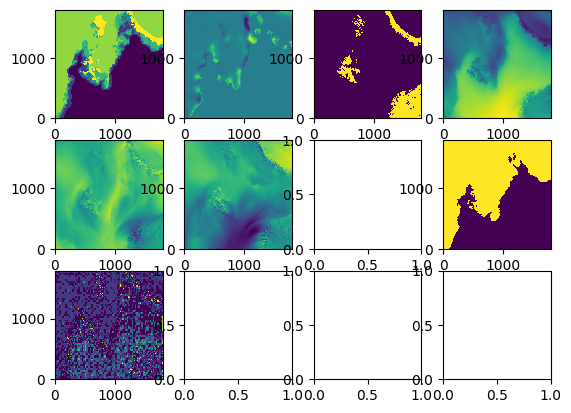

In [102]:
fig, ax = plt.subplots(2, 4)
ax[0, 0].pcolormesh(X[0,...,0])
ax[0, 1].pcolormesh(X[0,...,1])
ax[0, 2].pcolormesh(X[0,...,2])
ax[0, 3].pcolormesh(X[0,...,3])
ax[1, 0].pcolormesh(X[0,...,4])
ax[1, 1].pcolormesh(X[0,...,5])
ax[1, 3].pcolormesh(y[2, 0, :, :])

In [104]:
y_pred = model.predict(X)

1/1 [==============================] - 30s 30s/step


In [105]:
y_pred = tf.concat(y_pred, axis = -1)

In [106]:
out = tf.round(tf.nn.sigmoid(y_pred[0]))

In [107]:
out = np.apply_along_axis(numpy_where_wrapper, -1, out)[..., 0]

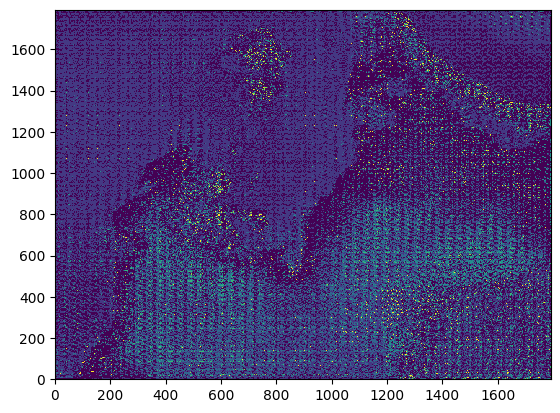

In [108]:
fig, ax = plt.subplots()
ax.pcolormesh(out)